In [37]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de componentes (ACP, MCA, FAMD)
import prince

# Preprocesamiento y clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# Distancias geográficas (si se usan coordenadas)
from sklearn.metrics.pairwise import haversine_distances

# Guardado y carga de modelos
import joblib

In [22]:
df = pd.read_csv('/media/fabian/INFO/Universidad externado/ML2/proyecto/data/datos_concatenados.csv')

In [23]:
df.columns

Index(['Ano', 'Presunto_Responsable', 'Total_de_Victimas_del_Caso', 'Latitud',
       'Longitud'],
      dtype='object')

# Primer intento (fallido)

In [9]:
#df.drop(columns=['Municipio'], inplace=True)
#df['Otro_Hecho_Simultaneo'].value_counts()

In [64]:
cols_utiles = [
    'Ano',                  # numérica (año del hecho)
    'Latitud', 'Longitud',  # numéricas (ubicación del hecho)
    'hecho_simultaneo_cat', # categórica (combinación de modalidades)
    'categoria'             # categórica (nivel general del hecho)
]

In [65]:
# columnas numéricas
num_cols  = ['Ano', 'Latitud', 'Longitud']

# columnas categóricas (ya limpias)
cat_cols  = [
    'Presunto_Responsable',
    'categoria'                  # 0-31
]

cols = num_cols + cat_cols


In [66]:
# numéricas → float / int; categóricas → dtype 'category'
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

for c in cat_cols:
    df[c] = df[c].astype('category')


## Ajustamos el modelo FAMD

In [67]:
# n_components: prueba 10 para empezar (ajusta arriba/abajo)
famd = prince.FAMD(
    n_components=100,
    random_state=42,
    copy=True
)

X_famd = famd.fit_transform(df[cols])


In [68]:
import joblib

# Guardar el modelo
joblib.dump(famd, 'famd_model.pkl')

# Más adelante, para cargarlo:
famd_loaded = joblib.load('famd_model.pkl')


In [69]:
# % de inercia (varianza) que explica cada componente
print("Porcentaje por componente:\n",
      famd.percentage_of_variance_)          # array de tamaño n_components

# % acumulado
print("\nPorcentaje acumulado:\n",
      famd.cumulative_percentage_of_variance_)

# En forma de Serie si quieres plotear rápido
import pandas as pd
cumul = pd.Series(famd.cumulative_percentage_of_variance_,
                  name='% inercia acumulada')
print(cumul)


Porcentaje por componente:
 [1.54203787 1.35147776 1.13946912 1.04784479 1.02228604 0.96192201
 0.9559455  0.93158503 0.92792021 0.9146771  0.91093038 0.90328015
 0.89889008 0.89573567 0.890172   0.88726265 0.88514539 0.88195747
 0.88076773 0.87823993 0.8743789  0.87172394 0.86951916 0.8693079
 0.86873725 0.86729206 0.86631608 0.86293153 0.86271848 0.86233506
 0.86104719 0.85939156 0.85817004 0.85635138 0.85595621 0.85447824
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273 0.85227273
 0.85227273 0.85227273 0.85218774 0.84987469 0.84840058 0.84750671
 0.84668689 0.84607053 0.84410585 0.84221341 0.84123599 0.83957518
 0.83847641 0.83720584 0.83575084 0

Text(0.5, 1.0, 'Curva de varianza • FAMD')

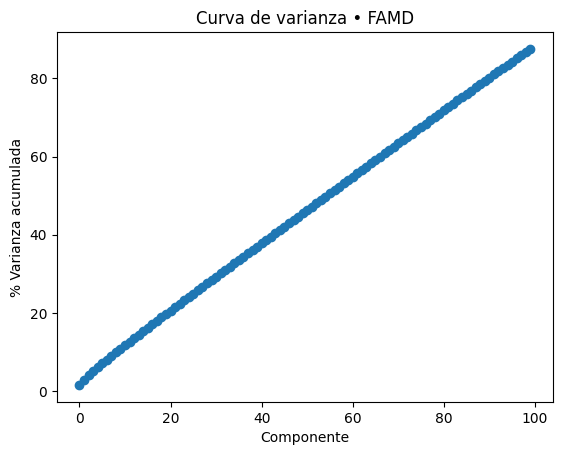

In [70]:
ax = cumul.plot(marker='o')
ax.set_xlabel('Componente')
ax.set_ylabel('% Varianza acumulada')
ax.set_title('Curva de varianza • FAMD')


## Separar train / val / test (70 / 15 / 15)

In [72]:
from sklearn.model_selection import train_test_split

X = df[cols].copy()                 # num + cat, ya limpios
X_train_val, X_test = train_test_split(X, test_size=0.15,
                                       random_state=42, shuffle=True)
X_train, X_val = train_test_split(X_train_val, test_size=0.1765,
                                  random_state=42, shuffle=True)


## Ajustar FAMD solo con train

In [73]:
famd = prince.FAMD(n_components=80, random_state=42).fit(X_train)
Z_train = famd.transform(X_train)
Z_val   = famd.transform(X_val)
Z_test  = famd.transform(X_test)


## Escalado de los componentes

In [74]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_val   = scaler.transform(Z_val)
Z_test  = scaler.transform(Z_test)


## Calibrar y entrenar DBSCAN en train

1.  Calcula la distancia al k-ésimo vecino (k ≈ min_samples) para los puntos de Z_train y grafica el “codo”.

2.  Escoge eps donde la curva se inflexiona.

3.  Ajusta DBSCAN.

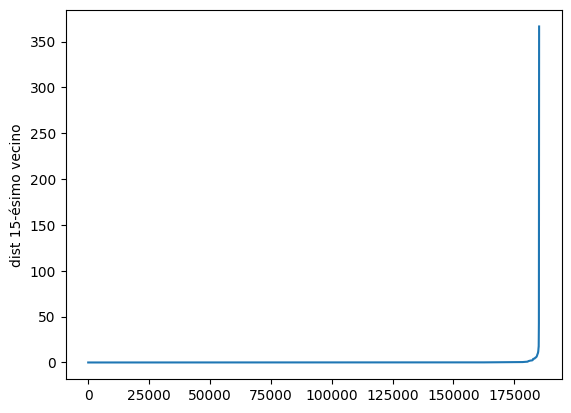

In [75]:
from sklearn.neighbors import NearestNeighbors
import numpy as np, matplotlib.pyplot as plt

k = 15
nbrs = NearestNeighbors(n_neighbors=k).fit(Z_train)
dists, _ = nbrs.kneighbors(Z_train)
k_dist = np.sort(dists[:, -1])

plt.plot(k_dist); plt.ylabel(f'dist {k}-ésimo vecino'); plt.show()

# Suponiendo que el “codo” está en ~1.3
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.3, min_samples=k).fit(Z_train)
labels_train = db.labels_


##   Etiquetar val / test sin re-entrenar

In [76]:
from sklearn.neighbors import KNeighborsClassifier
core_mask = labels_train != -1
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(Z_train[core_mask], labels_train[core_mask])
labels_val  = knn.predict(Z_val)
labels_test = knn.predict(Z_test)


##   Validación sin fuga

In [77]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette (val):",
      silhouette_score(Z_val, labels_val))
print("Davies–Bouldin (val):",
      davies_bouldin_score(Z_val, labels_val))


Silhouette (val): 0.6850116681187687
Davies–Bouldin (val): 1.6813955772980873


In [78]:
import numpy as np
print("Número de clústeres (excluyendo ruido):", len(np.unique(labels_val)) - (1 if -1 in labels_val else 0))
print("Porcentaje de puntos como ruido:", np.mean(labels_val == -1) * 100, "%")


Número de clústeres (excluyendo ruido): 441
Porcentaje de puntos como ruido: 0.0 %


In [79]:
import pandas as pd
pd.Series(labels_val).value_counts().sort_index()


0      1497
1        18
2       493
3       258
4       197
       ... 
438       1
439       6
440       9
441       3
442      28
Name: count, Length: 441, dtype: int64

/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/skl

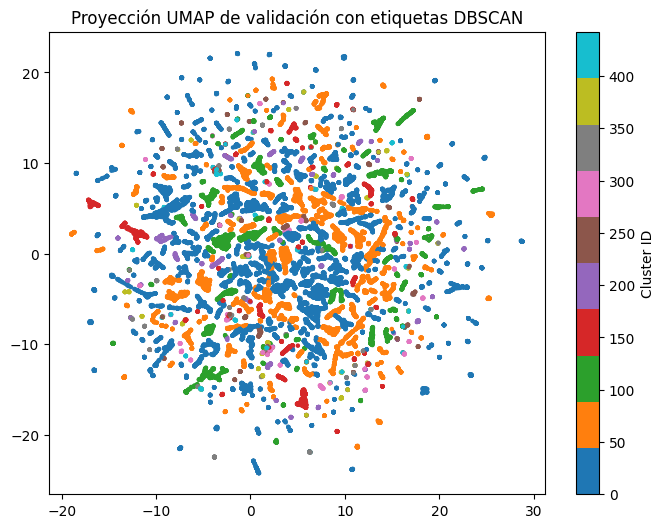

In [84]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
Z_umap = reducer.fit_transform(Z_val)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c=labels_val, cmap='tab10', s=5)
plt.title('Proyección UMAP de validación con etiquetas DBSCAN')
plt.colorbar(label='Cluster ID')
plt.show()


# Segundo intento

## DBSCAN

In [24]:
# columnas numéricas
num_cols  = ['Ano', 'Latitud', 'Longitud','Total_de_Victimas_del_Caso']

# columnas categóricas (ya limpias)
cat_cols  = [
    'Presunto_Responsable',
]

cols = num_cols + cat_cols

### Nota: como estamos realizando clusterin no es necesario realizar separacion de datos, solo hacer una transformacion

In [ ]:
# Conversión de lat/lon a radianes  
coords_rad = np.radians(df[['Latitud', 'Longitud']].to_numpy())

# Escalado de la variable 'año' para que entre en la misma magnitud --
year_scaled = StandardScaler().fit_transform(df[['Ano']])


# Concatenar y definir métrica 
X = np.hstack([coords_rad, year_scaled])


In [ ]:

def spatiotemporal(u, v, alpha=1.0):
    # u,v = [lat, lon, year_scaled]
    # Extra la lat y lon que esta en radianes , convierte el arreglo en 2d con reshape(1,-1)
    # El resultado es una distancia angular en radianes. para convertirla en en kilometros,
    # multiplicada por el radio terrestre  (6371km)
    spatial = haversine_distances(u[:2].reshape(1,-1), v[:2].reshape(1,-1))[0,0] 
    temporal = np.abs(u[2]-v[2]) # Calcula la distancia temporal asumiendo que son años  escalados
    return np.sqrt(spatial**2 + (alpha*temporal)**2)
"""
Devuelve la distancia espaciotemporal combinada

    Combina espacio y tiempo usando una versión de distancia euclídea ponderada.

    alpha ajusta la importancia relativa del tiempo frente al espacio. Por ejemplo:

        alpha = 1 tiempo y espacio en igual escala.

        alpha > 1 da más peso al tiempo.

        alpha < 1  da más peso al espacio.
        
        Referencia: Birant & Kut (2007) proponen este enfoque en su algoritmo ST-DBSCAN.
"""

# Crea el modelo DBSCAN  y los ajusta a los datos
db = DBSCAN(eps=0.01,       # ≈ 1 km si eps en radianes /umbral de distancia 
            min_samples=10, #Minimo de puntos en la vecindad 
            metric=spatiotemporal).fit(X) # le pasamos la funcion personalizada definida con anterioridad
df['cluster'] = db.labels_ #Guarda los resultados del cluster

## Vamos a clasificar los puntos para visualizarlos y entender la relacion
### Clasificamos los puntos

## GMM

In [25]:
cols_num = ['Ano', 'Latitud', 'Longitud', 'Total_de_Victimas_del_Caso']
col_cat  = 'Presunto_Responsable'
X = df[cols_num + [col_cat]].copy()


## Aplicando getdummis

In [26]:
## Aplicando getdummis
X = pd.get_dummies(
    X,
    columns=['Presunto_Responsable'],       # columnas a transformar
    drop_first=True,                 # si True, elimina la primera categoría para evitar multicolinealidad
    dtype=int                         # tipo de dato de las dummies
)

In [ ]:

# Conversión de lat/lon a radianes  
coords_rad = np.radians(X[['Latitud', 'Longitud']].to_numpy())

# Escalado de la variable 'año' para que entre en la misma magnitud --
year_scaled = StandardScaler().fit_transform(X[['Ano']])

# Escalar 'Total_de_Victimas_del_Caso'

vict_scaled = StandardScaler().fit_transform(
    X[['Total_de_Victimas_del_Caso']]
)

# Extraer las dummies de Presunto_Responsable ------------------------
dummy_cols = X.filter(like='Presunto_Responsable_').to_numpy()

# --- 3. Construir la matriz final 
# year_scaled              -> shape (n, 1)
# coords_rad               -> shape (n, 2)
# vict_scaled arriba                   -> shape (n, 1)
# dummy_cols                           -> shape (n, k)

X_final = np.hstack([
    year_scaled,        # Año (escala ~N(0,1))
    coords_rad,         # Latitud, Longitud en radianes
    vict_scaled,        # Víctimas (escala ~N(0,1))
    dummy_cols          # Dummies 0/1
])

print("Shape final:", X_final.shape)   # (n_samples, n_features)

#DataFrame con nombres legibles:

cols_final = (['Ano_z'] +
              ['Lat_rad', 'Lon_rad'] +
              ['Victimas_z'] +
              list(X.filter(like='Presunto_Responsable_').columns))

X_final_df = pd.DataFrame(X_final, columns=cols_final, index=X.index)
X_final_df.head()



Shape final: (264536, 16)


## El mejor k según BIC (o AIC)
###  Ajustar GMM para varios k y guardar BIC / AIC

In [ ]:
ks = range(2, 16)          # pruebamos entre 2 y 15 componentes
bics, aics, gmms = [], [], []

for k in ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',     # también 'tied' o 'diag' si quieres probar
        random_state=42,
        n_init=3                    # reintenta con 3 inicializaciones
    ).fit(X_final_df)

    bics.append(gmm.bic(X_final_df))
    aics.append(gmm.aic(X_final_df))
    gmms.append(gmm)

# Elegir el mejor k según BIC (o AIC)
best_k_bic = ks[int(np.argmin(bics))]
best_k_aic = ks[int(np.argmin(aics))]
print(f"Mejor k por BIC: {best_k_bic}")
print(f"Mejor k por AIC: {best_k_aic}")

Mejor k por BIC: 15
Mejor k por AIC: 15


## Graficar curva BIC / AIC para ver la tendencia

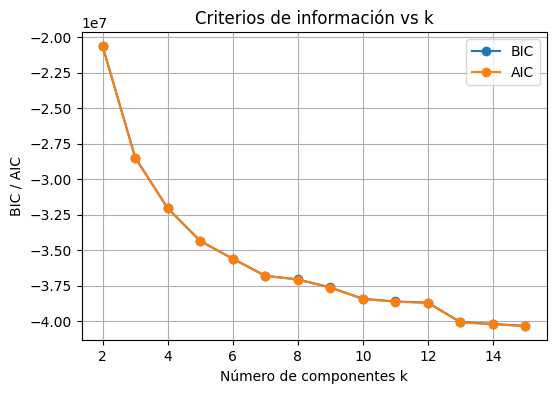

In [31]:
plt.figure(figsize=(6,4))
plt.plot(ks, bics, label='BIC', marker='o')
plt.plot(ks, aics, label='AIC', marker='o')
plt.xlabel('Número de componentes k')
plt.ylabel('BIC / AIC')
plt.title('Criterios de información vs k')
plt.legend(); plt.grid(True); plt.show()

### Ajustar GMM definitivo con el mejor k (por BIC)

In [32]:
# Ajustar el modelo con el mejor número de componentes (best_k_bic)
best_gmm = GaussianMixture(
    n_components=best_k_bic,
    covariance_type='full',
    random_state=42,
    n_init=5
).fit(X_final_df.to_numpy())

# Predicción y probabilidades
labels_gmm = best_gmm.predict(X_final_df.to_numpy())
proba_max  = best_gmm.predict_proba(X_final_df.to_numpy()).max(axis=1)

# Añadir a tu df original
df['gmm_cluster'] = labels_gmm
df['gmm_conf']    = proba_max

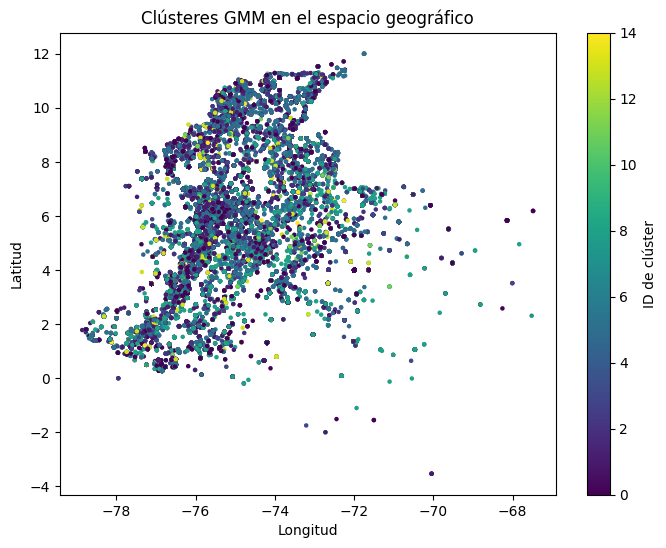

In [33]:
N = len(df)
# Para que la gráfica no sea demasiado pesada, muestreamos si hay >50k puntos
sample_df = df if N <= 50000 else df.sample(50000, random_state=42)

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    sample_df['Longitud'],
    sample_df['Latitud'],
    c=sample_df['gmm_cluster'],
    s=5
)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clústeres GMM en el espacio geográfico')
plt.colorbar(sc, label='ID de clúster')
plt.show()

In [ ]:
# 1. Guardar el modelo GMM entrenado
joblib.dump(best_gmm, 'best_gmm_model.pkl')

# 2. Preparar DataFrame de resultados
df['gmm_cluster'] = labels_gmm
df['gmm_conf']    = proba_max

# Seleccionamos las columnas a guardar
cols_to_save = ['gmm_cluster', 'gmm_conf']
# Si existe alguna columna de etiqueta original (por ejemplo 'label'), la añadimos
if 'label' in df.columns:
    cols_to_save.append('label')

# Creamos un DataFrame solo con esas columnas
results_df = df[cols_to_save]

# 3. Guardar a CSV
results_df.to_csv('gmm_results.csv', index=False)

print("Modelo guardado en 'best_gmm_model.pkl' y resultados en 'gmm_results.csv'")


Modelo guardado en 'best_gmm_model.pkl' y resultados en 'gmm_results.csv'


In [35]:
try:
    import umap.umap_ as umap
    reducer = umap.UMAP(random_state=42, n_neighbors=30, min_dist=0.3)
    Z_umap = reducer.fit_transform(df[['Ano', 'Latitud', 'Longitud', 'Total_de_Victimas_del_Caso']].join(
        df.filter(like='Presunto_Responsable_')
    ).to_numpy())

    plt.figure(figsize=(8, 6))
    sc2 = plt.scatter(
        Z_umap[:, 0],
        Z_umap[:, 1],
        c=df['gmm_cluster'],
        s=5
    )
    plt.title('Proyección UMAP de los clústeres GMM')
    plt.colorbar(sc2, label='ID de clúster')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()
except ModuleNotFoundError:
    print("¶ Para la proyección UMAP necesitas instalar umap-learn:\n   pip install umap-learn")


/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fabian/miniconda3/envs/islp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 